# Height GWAS Separate train and test

This is GWAS analysis for tz2014 data to find snps associate with height

## 1. Import

In [1]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR
from scipy import stats

import matplotlib.pyplot as plt

#from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from sklearn import linear_model
import random

## 2. Load Data

In [4]:
(tz_bim,tz_fam,tz_bed) = read_plink('ddat/crowdAI/all2964/bin_final_strand')

Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.18s/it]


In [5]:
tz_maf =  pd.read_csv(PATH/'TZ14_one.frq',delim_whitespace=True)

In [6]:
all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)

## 3. Clean Data

In [7]:
def select_snp(arr):
    if arr[0]==0 or arr[0]==26:
        return 0
    elif arr[4]<0.05 or arr[4]>0.95:
        return 0
    elif arr[2]=='A' and arr[3]=='T':
        return 0
    elif arr[2]=='T' and arr[3]=='A':
        return 0
    elif arr[2]=='G' and arr[3]=='C':
        return 0
    elif arr[2]=='C' and arr[3]=='G':
        return 0
    else:
        return 1

In [8]:
def plink_slice(p,pb=None,pf=None):
    """
    p: list of bim, fam, bed
    pb: index of bim
    pf: index of fam
    """
    (bim,fam,bed)=p
    if pb:
        bim = bim.iloc[pb]
        bed = bed[pb,:]
    if pf:
        fam = fam.iloc[pf]
        bed = bed[:,pf]
    return(bim,fam,bed)

In [9]:
tz_maf_filter = tz_maf.apply(select_snp, axis=1)
tz_maf_new=tz_maf.loc[tz_maf_filter==1,]

In [10]:
tz_sample_index = [i for i,x in enumerate(tz_fam.iid) if x in list(all_meta.ChipID)]
tz_sub=plink_slice((tz_bim,tz_fam,tz_bed),list(tz_maf_new.index),tz_sample_index)

## 4. GWAS Model

### 4.1 Linear GWAS

In [11]:
tz_meta=all_meta.loc[tz_sub[1].iid,]

In [12]:
samp_size=len(tz_meta)
train_ratio = 0.8
train_size = int(samp_size * train_ratio)
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)

2747 2197


In [17]:
pd.Series(val_idx).to_csv('TTS_Model/gwas_val_idx.csv')

In [18]:
tz_snps=tz_sub[2].compute()

In [20]:
tz_snps = pd.DataFrame(tz_snps)

In [22]:
tz_snps.fillna(-1,inplace=True)

In [25]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, tz_snps.T.values, tz_meta)

In [29]:
val.shape,trn.shape,y_val.shape,y_trn.shape

((550, 684066), (2197, 684066), (550, 8), (2197, 8))

In [31]:
sum(y_val.gender==1)

208

In [36]:
x = y_trn.gender.values
y = y_trn.height.values
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
y_residual = y-(intercept + slope*x)
y_rtest = y_val.height-(intercept+slope*y_val.gender)

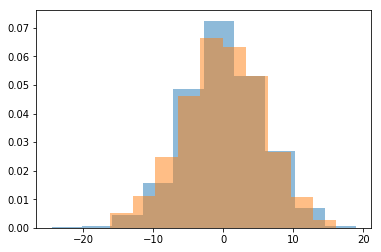

In [37]:
plt.hist(y_residual,density=True,alpha=0.5)
plt.hist(y_rtest,density=True,alpha=0.5)
plt.show()

In [57]:
trn_result={}
val_result={}
for i,t,v in zip(list(range(trn.shape[1])),trn.T,val.T):
    trn_result[i]=list(stats.linregress(t,y_residual))
    val_result[i]=list(stats.linregress(v,y_rtest))


In [61]:
def save_gwas(gwas,plink,path=None):
    snps_gwas=pd.DataFrame(gwas)
    snp_pv_idx=list(np.argsort(snps_gwas.iloc[3,]))
    snps_gwas=snps_gwas.iloc[:,snp_pv_idx].T
    snps_gwas.columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']
    snps_gwas['prank'] = snp_pv_idx
    new_plink=plink_slice(plink,snp_pv_idx)
    snps_gwas.index = list(new_plink[0].snp)
    snps_gwas.to_csv(path)
    

In [62]:
save_gwas(trn_result,tz_sub,path='TTS_Model/gwas_trn_result.csv')

In [63]:
save_gwas(val_result,tz_sub,path='TTS_Model/gwas_val_result.csv')

In [50]:
from snp2h import boo2idx

In [51]:
f_trn_idx = boo2idx(y_trn.gender==2)

In [64]:
((f_trn,m_trn), (f_ytr,m_ytr)) = split_by_idx(f_trn_idx, trn, y_residual)

In [65]:
f_trn.shape,m_trn.shape

((1416, 684066), (781, 684066))

In [67]:
f_trn_result={}
m_trn_result={}
for i,t,v in zip(list(range(f_trn.shape[1])),f_trn.T,m_trn.T):
    f_trn_result[i]=list(stats.linregress(t,f_ytr))
    m_trn_result[i]=list(stats.linregress(v,m_ytr))

In [68]:
save_gwas(f_trn_result,tz_sub,path='TTS_Model/gwas_trn_result_female.csv')
save_gwas(m_trn_result,tz_sub,path='TTS_Model/gwas_trn_result_male.csv')